# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

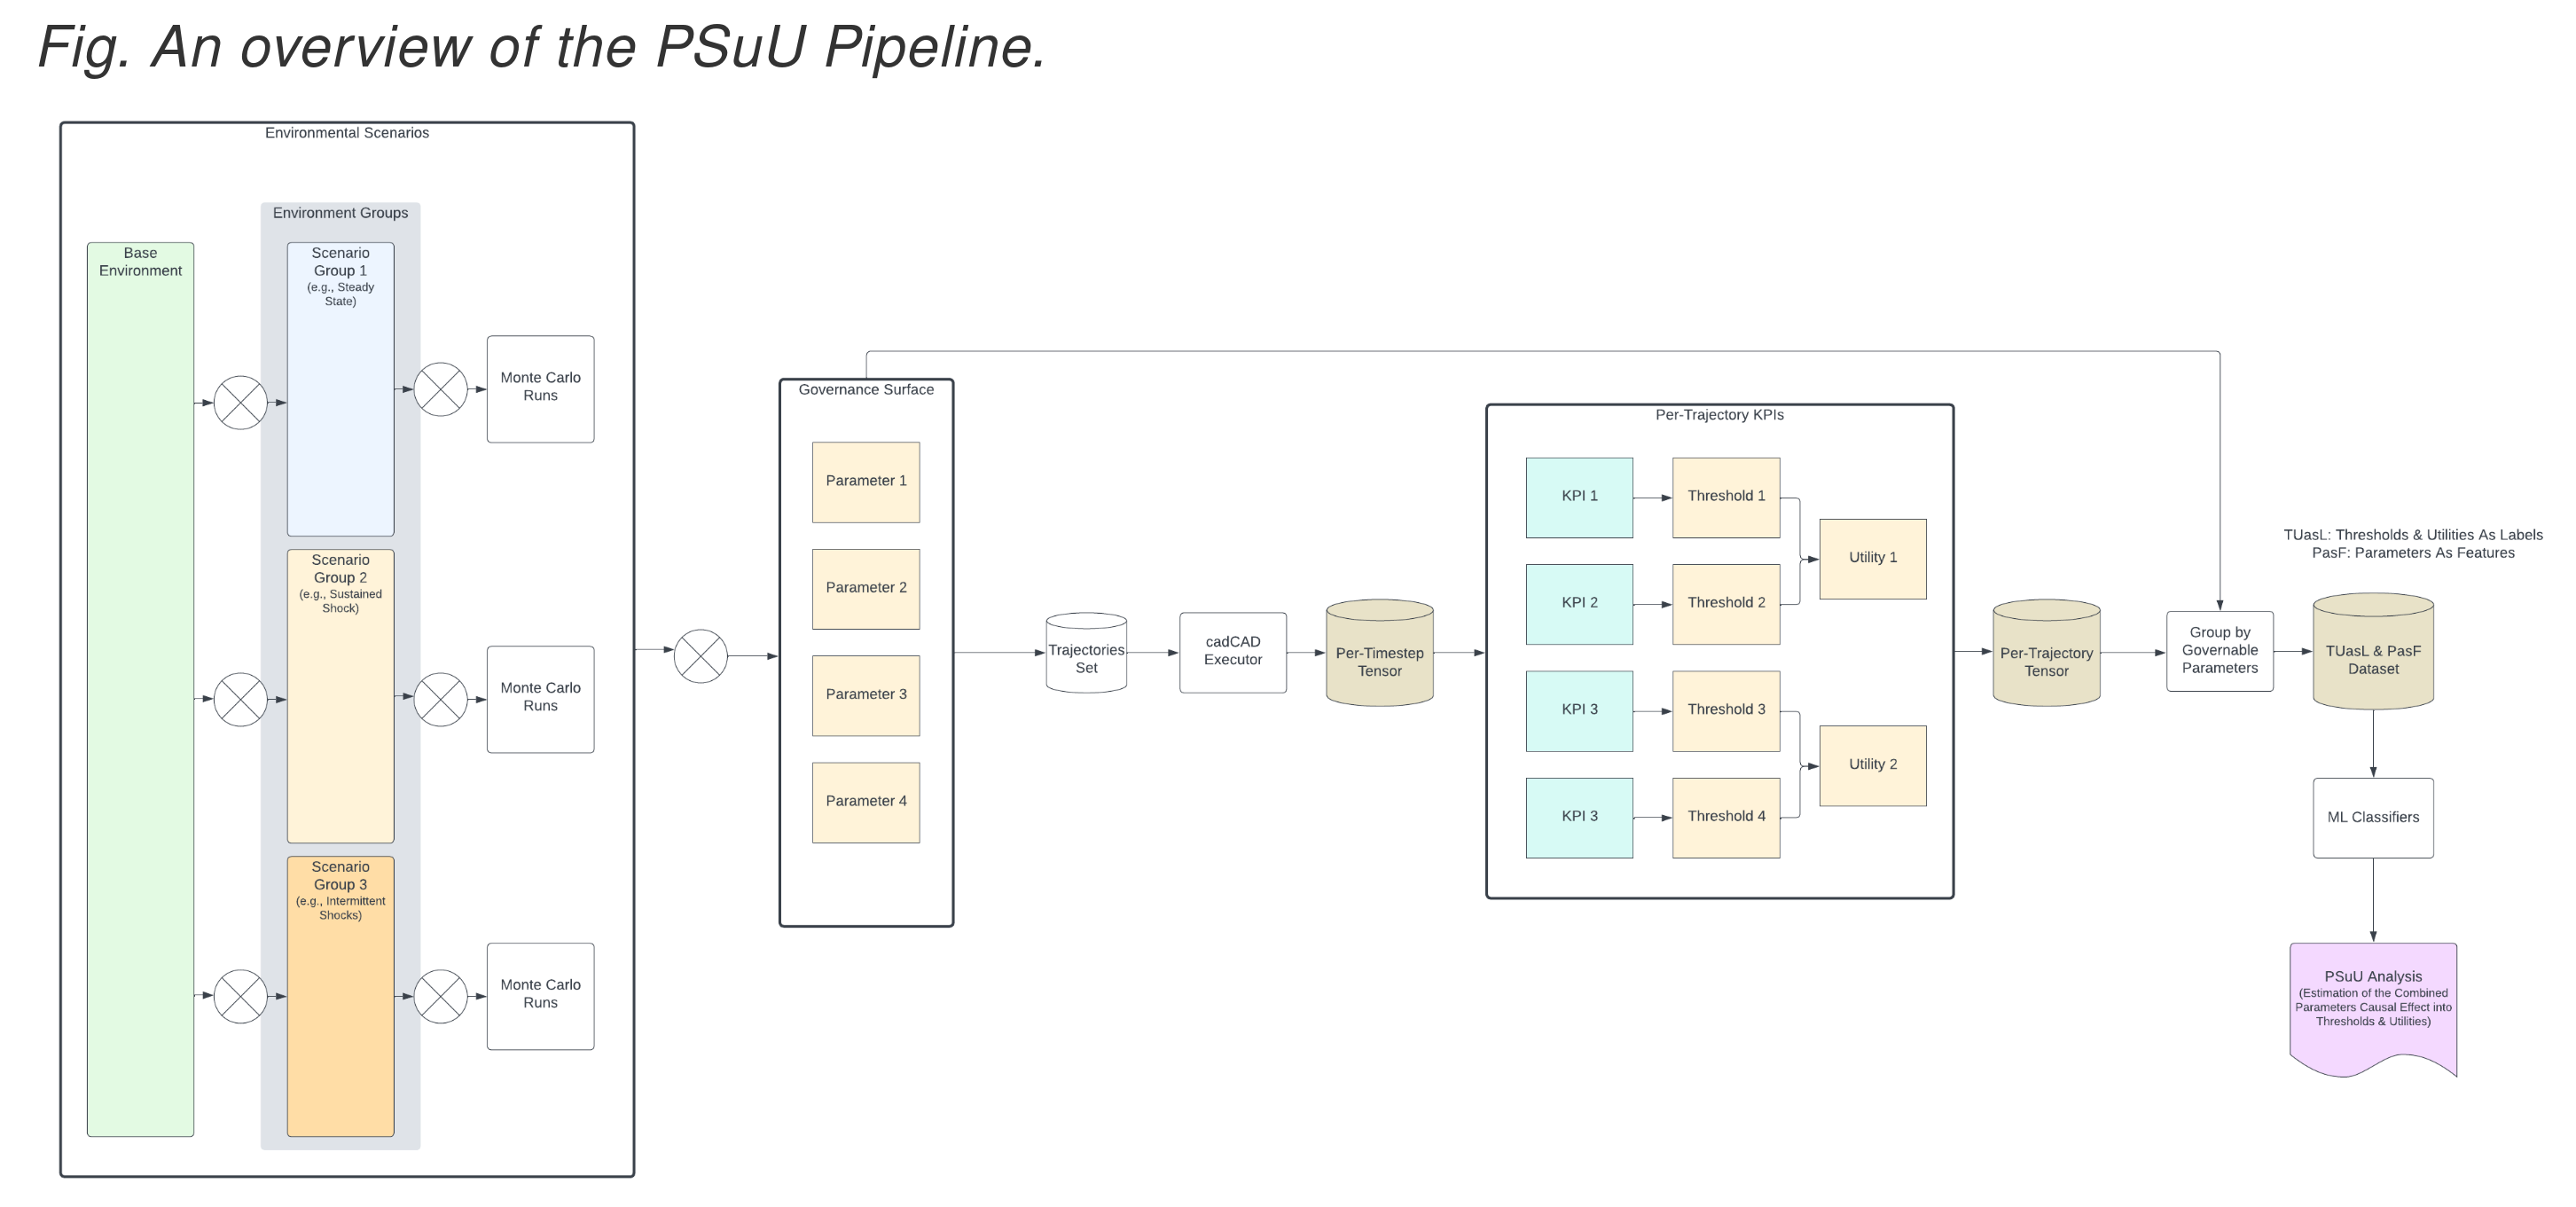

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import sys
sys.path.append('../../')

from glob import glob

latest = sorted(glob("../../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

In [2]:
sim_df.days_passed.max()

1096.0

Aggregating trajectories.

In [3]:
from subspace_model.psuu import timestep_tensor_to_trajectory_tensor, GOVERNANCE_SURFACE_PARAMS
agg_df = timestep_tensor_to_trajectory_tensor(sim_df).reset_index()

In [4]:
agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['subset', 'run']).describe()

,simulation,mean_relative_community_owned_supply,mean_farmer_subsidy_factor,mean_proposing_rewards_per_newly_pledged_space,mean_proposer_reward_minus_voter_reward,cumm_rewards_before_1yr,abs_sum_storage_fees_per_sum_compute_fees,cumm_rewards
count,96.0,96.000000,0.0,96.0,96.0,9.600000e+01,96.0,9.600000e+01
mean,0.0,1.192948,NaN,0.0,0.0,1.357800e+06,0.0,4.077120e+06
std,0.0,0.000435,NaN,0.0,0.0,8.616799e+05,0.0,2.587406e+06
min,0.0,1.192307,NaN,0.0,0.0,5.255980e+05,0.0,1.578238e+06
25%,0.0,1.192703,NaN,0.0,0.0,5.256025e+05,0.0,1.578243e+06
50%,0.0,1.192836,NaN,0.0,0.0,1.576795e+06,0.0,4.734715e+06
75%,0.0,1.193369,NaN,0.0,0.0,1.839601e+06,0.0,5.523841e+06
max,0.0,1.193369,NaN,0.0,0.0,2.628003e+06,0.0,7.891203e+06


Kernal density estimate plots of KPI outcomes over trajectories.

In [5]:
import hvplot.pandas

import holoviews as hv

df = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run'])

kde_plots = hv.Layout([df[col].hvplot.kde(title=col, fontscale=1.1, width=480) for col in df.columns]).cols(3)

kde_plots


:Layout
   .Distribution.I   :Distribution   [mean_relative_community_owned_supply]   (Density)
   .Distribution.II  :Distribution   [mean_farmer_subsidy_factor]   (Density)
   .Distribution.III :Distribution   [mean_proposing_rewards_per_newly_pledged_space]   (Density)
   .Distribution.IV  :Distribution   [mean_proposer_reward_minus_voter_reward]   (Density)
   .Distribution.V   :Distribution   [cumm_rewards_before_1yr]   (Density)
   .Distribution.VI  :Distribution   [abs_sum_storage_fees_per_sum_compute_fees]   (Density)
   .Distribution.VII :Distribution   [cumm_rewards]   (Density)

Evaluating the utility tensor.

In [6]:
from subspace_model.psuu.kpis import KPI_functions
from typing import Callable, Dict, List, Tuple, Union
import pandas as pd

# Type alias for a Criterion function
Criterion = Callable[[float, pd.Series], bool]

def evaluate(x: pd.Series, data: pd.DataFrame, success_criteria: Union[str, Criterion]) -> pd.Series:
    col_name = x.name  # Assuming col_name comes from the Series name
    if isinstance(success_criteria, str):
        if success_criteria == 'smaller_than_median':
            y = data.loc[:, col_name] < data.loc[:, col_name].median()
        elif success_criteria == 'larger_than_median':
            y = data.loc[:, col_name] > data.loc[:, col_name].median()
        else:
            raise Exception('Criteria not specified')
    else:
        y = data[col_name].map(lambda z: success_criteria(z, data[col_name]))
    return y

utility_dfs: List[pd.DataFrame] = []
for kpi, (kpi_f, threshold_f) in KPI_functions.items():
    kpi_df = agg_df[[kpi]]
    utility_df = kpi_df.apply(lambda x: evaluate(x, agg_df, threshold_f))
    utility_df.name = kpi
    utility_dfs.append(utility_df)

utility_df: pd.DataFrame = pd.concat(utility_dfs, axis=1).astype(int)
utility_df.index = agg_df.set_index(GOVERNANCE_SURFACE_PARAMS+['simulation', 'subset', 'run']).index

/home/ygg/.cache/pypoetry/virtualenvs/subspace-coCRCIcc-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [7]:
utility_df.reset_index(drop=True)

,mean_relative_community_owned_supply,mean_farmer_subsidy_factor,mean_proposing_rewards_per_newly_pledged_space,mean_proposer_reward_minus_voter_reward,cumm_rewards_before_1yr,abs_sum_storage_fees_per_sum_compute_fees,cumm_rewards
0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
91,0,0,0,0,1,0,0
92,1,0,0,0,0,0,1
93,1,0,0,0,0,0,1
94,1,0,0,0,0,0,1


In [8]:
utility_df.groupby('subset').mean().hvplot.heatmap(rot=25, height=800, width=1000, fontscale=1, cmap='RdYlGn', title='Utility outcomes by Parameter Subset', ylabel='Parameter Subset', xlabel='KPI Utility')

:HeatMap   [columns,index]   (value)

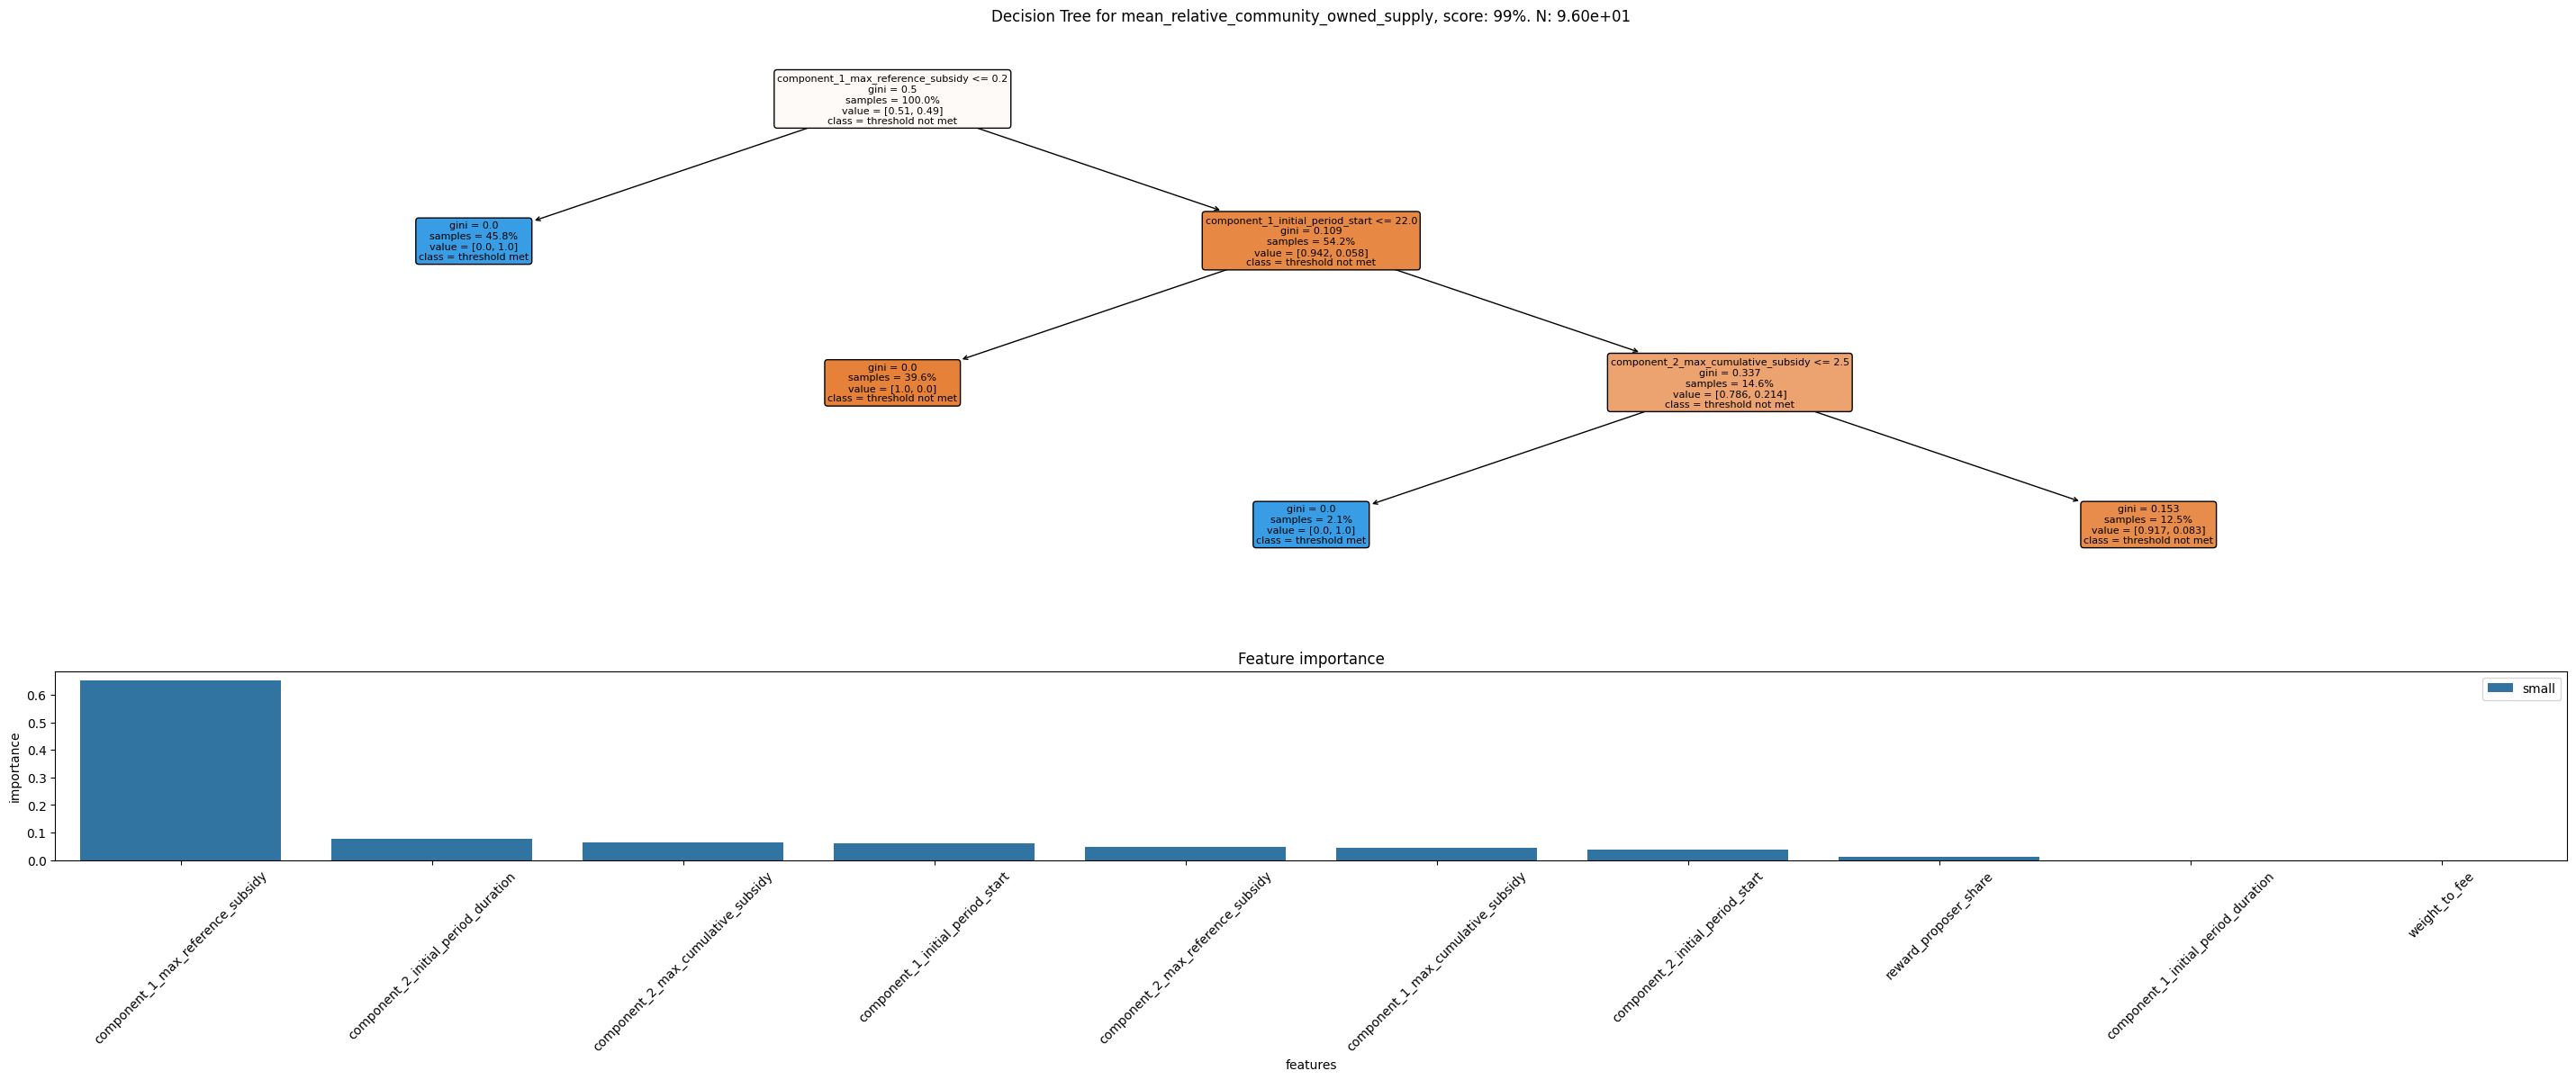

/home/ygg/.cache/pypoetry/virtualenvs/subspace-coCRCIcc-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


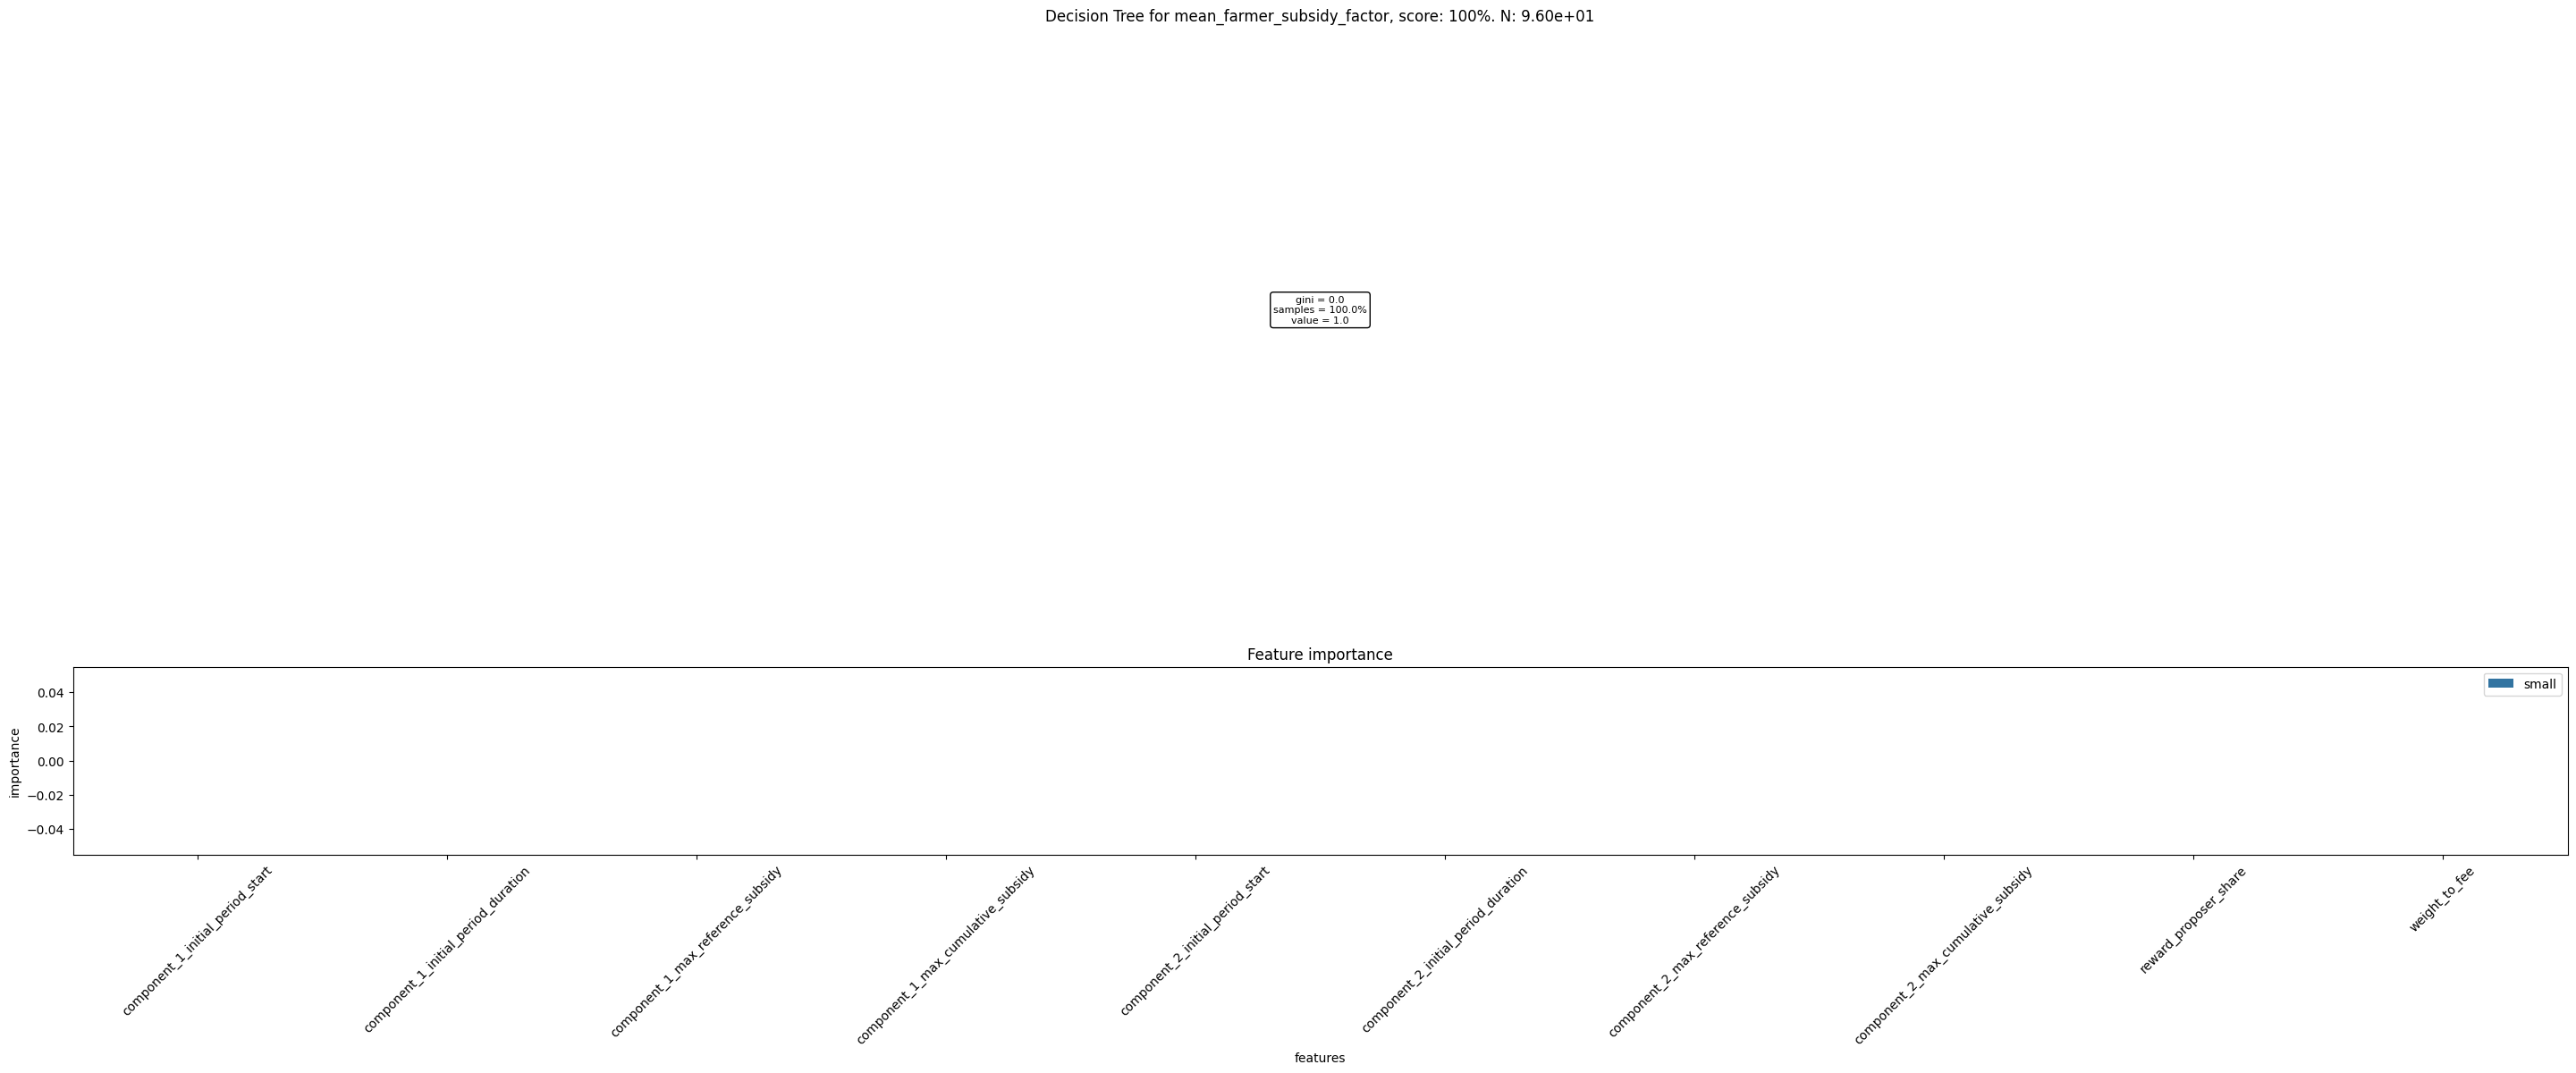

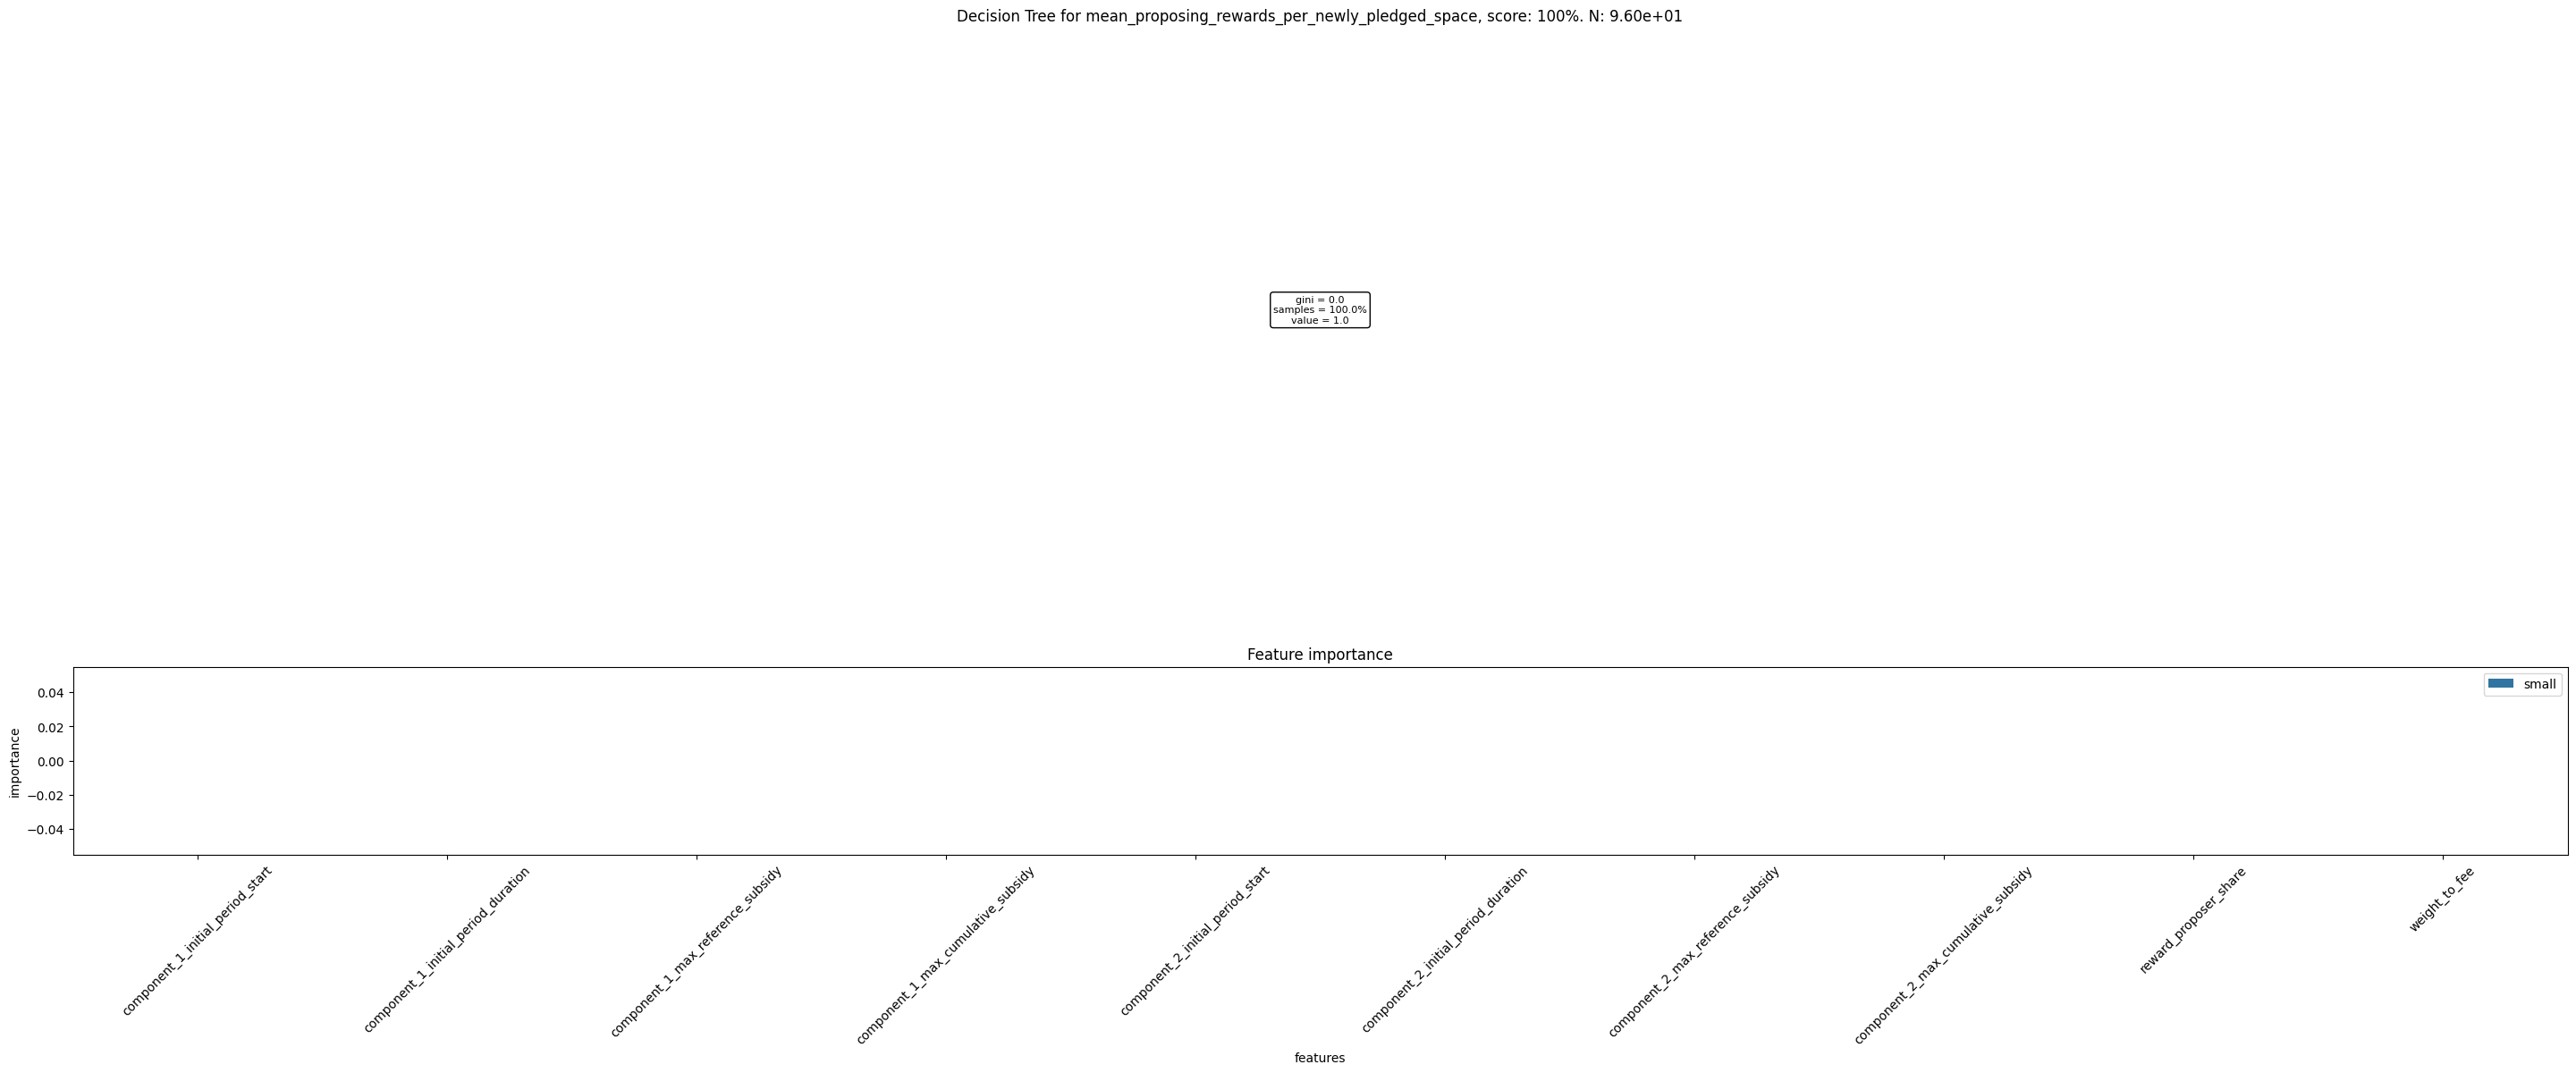

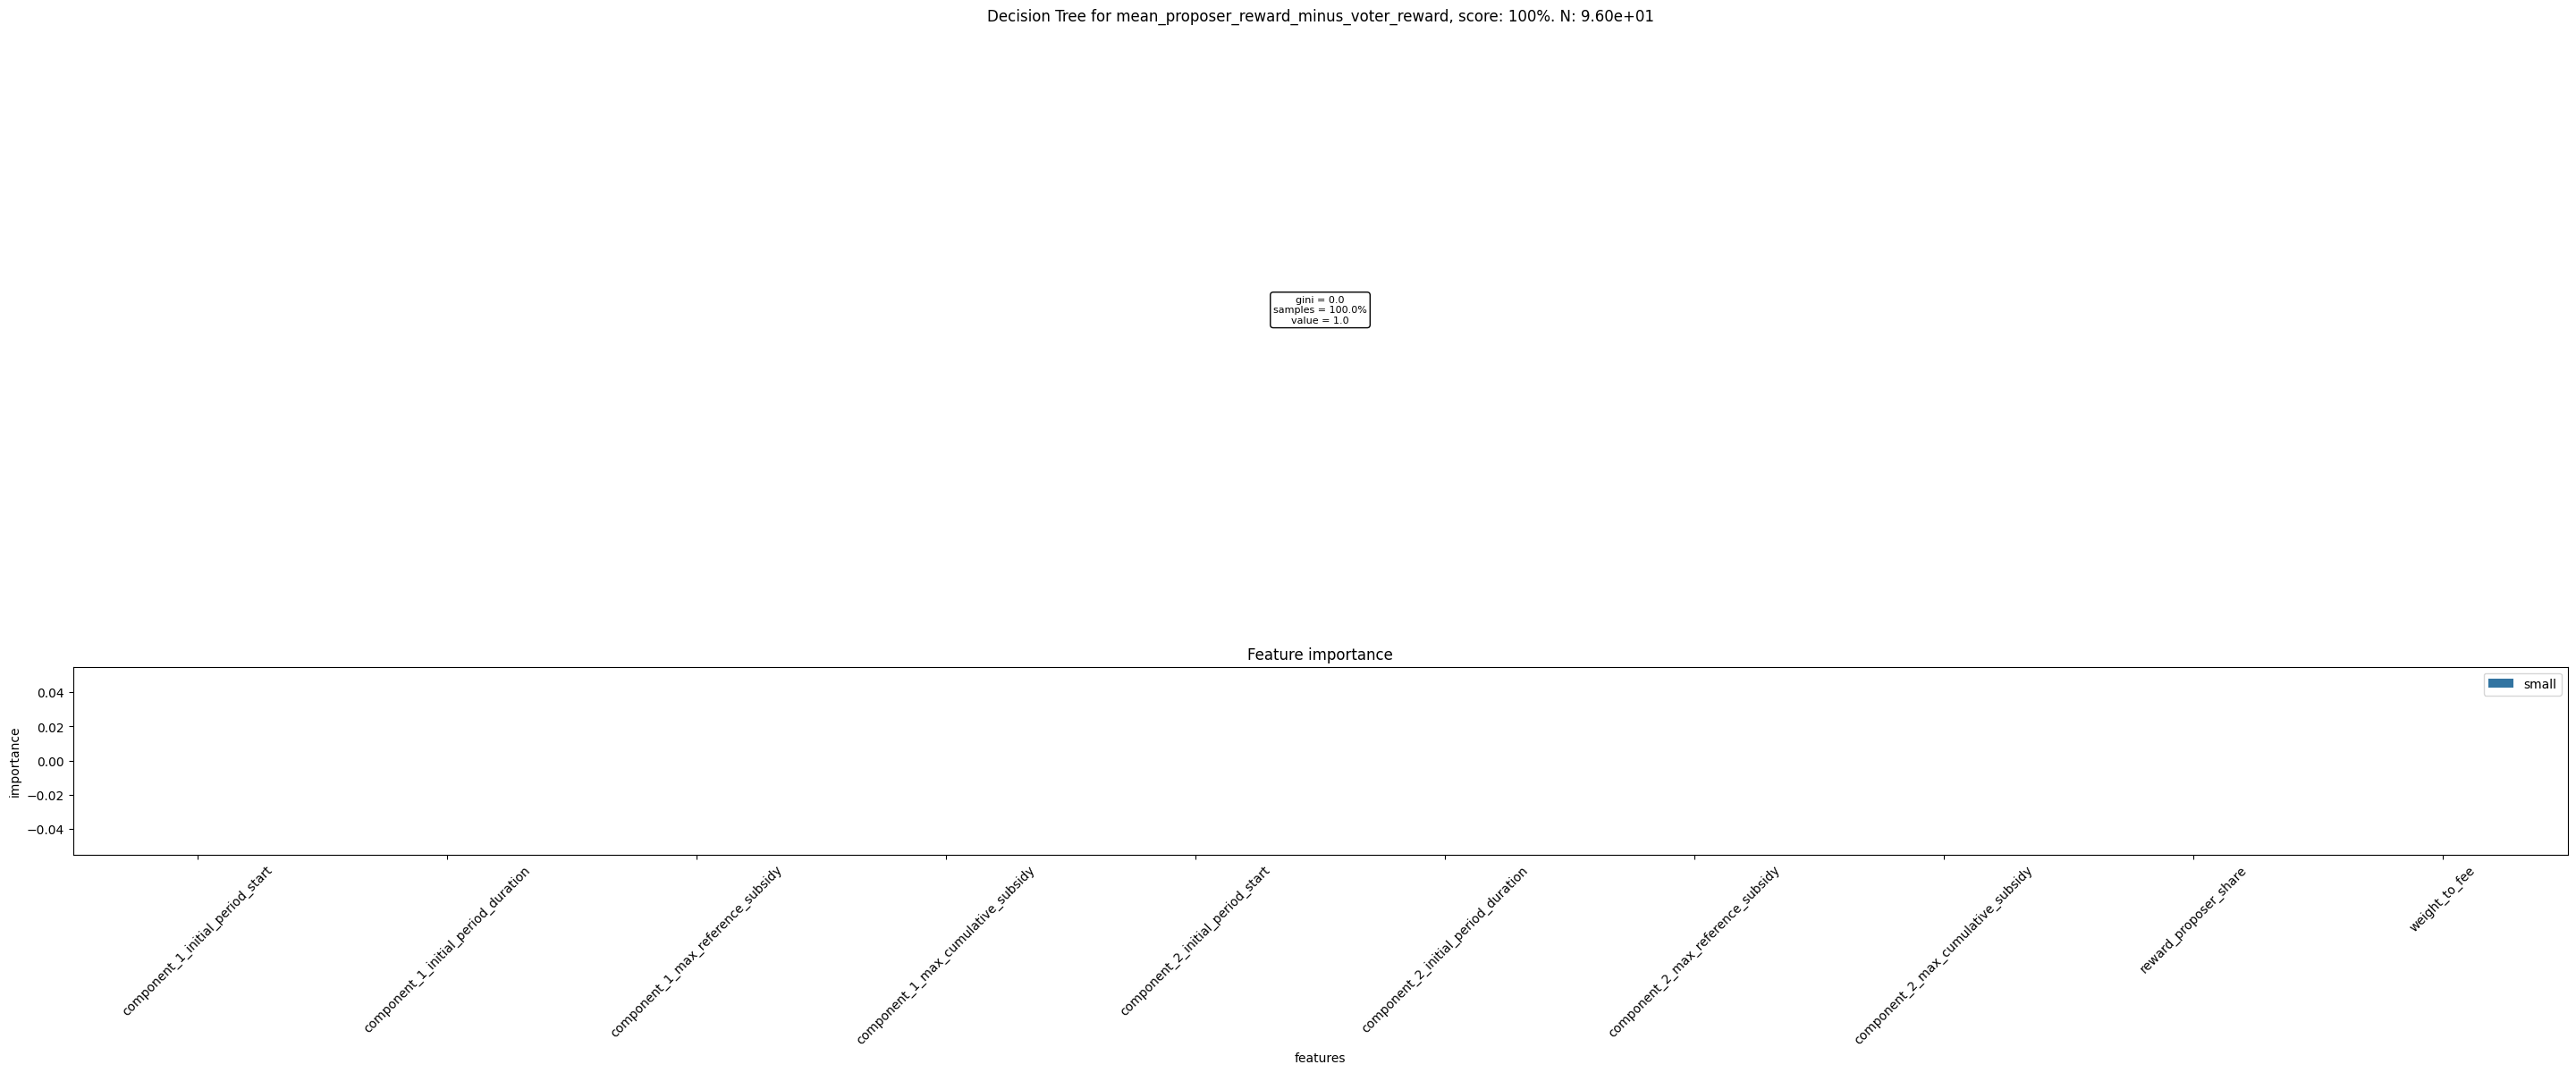

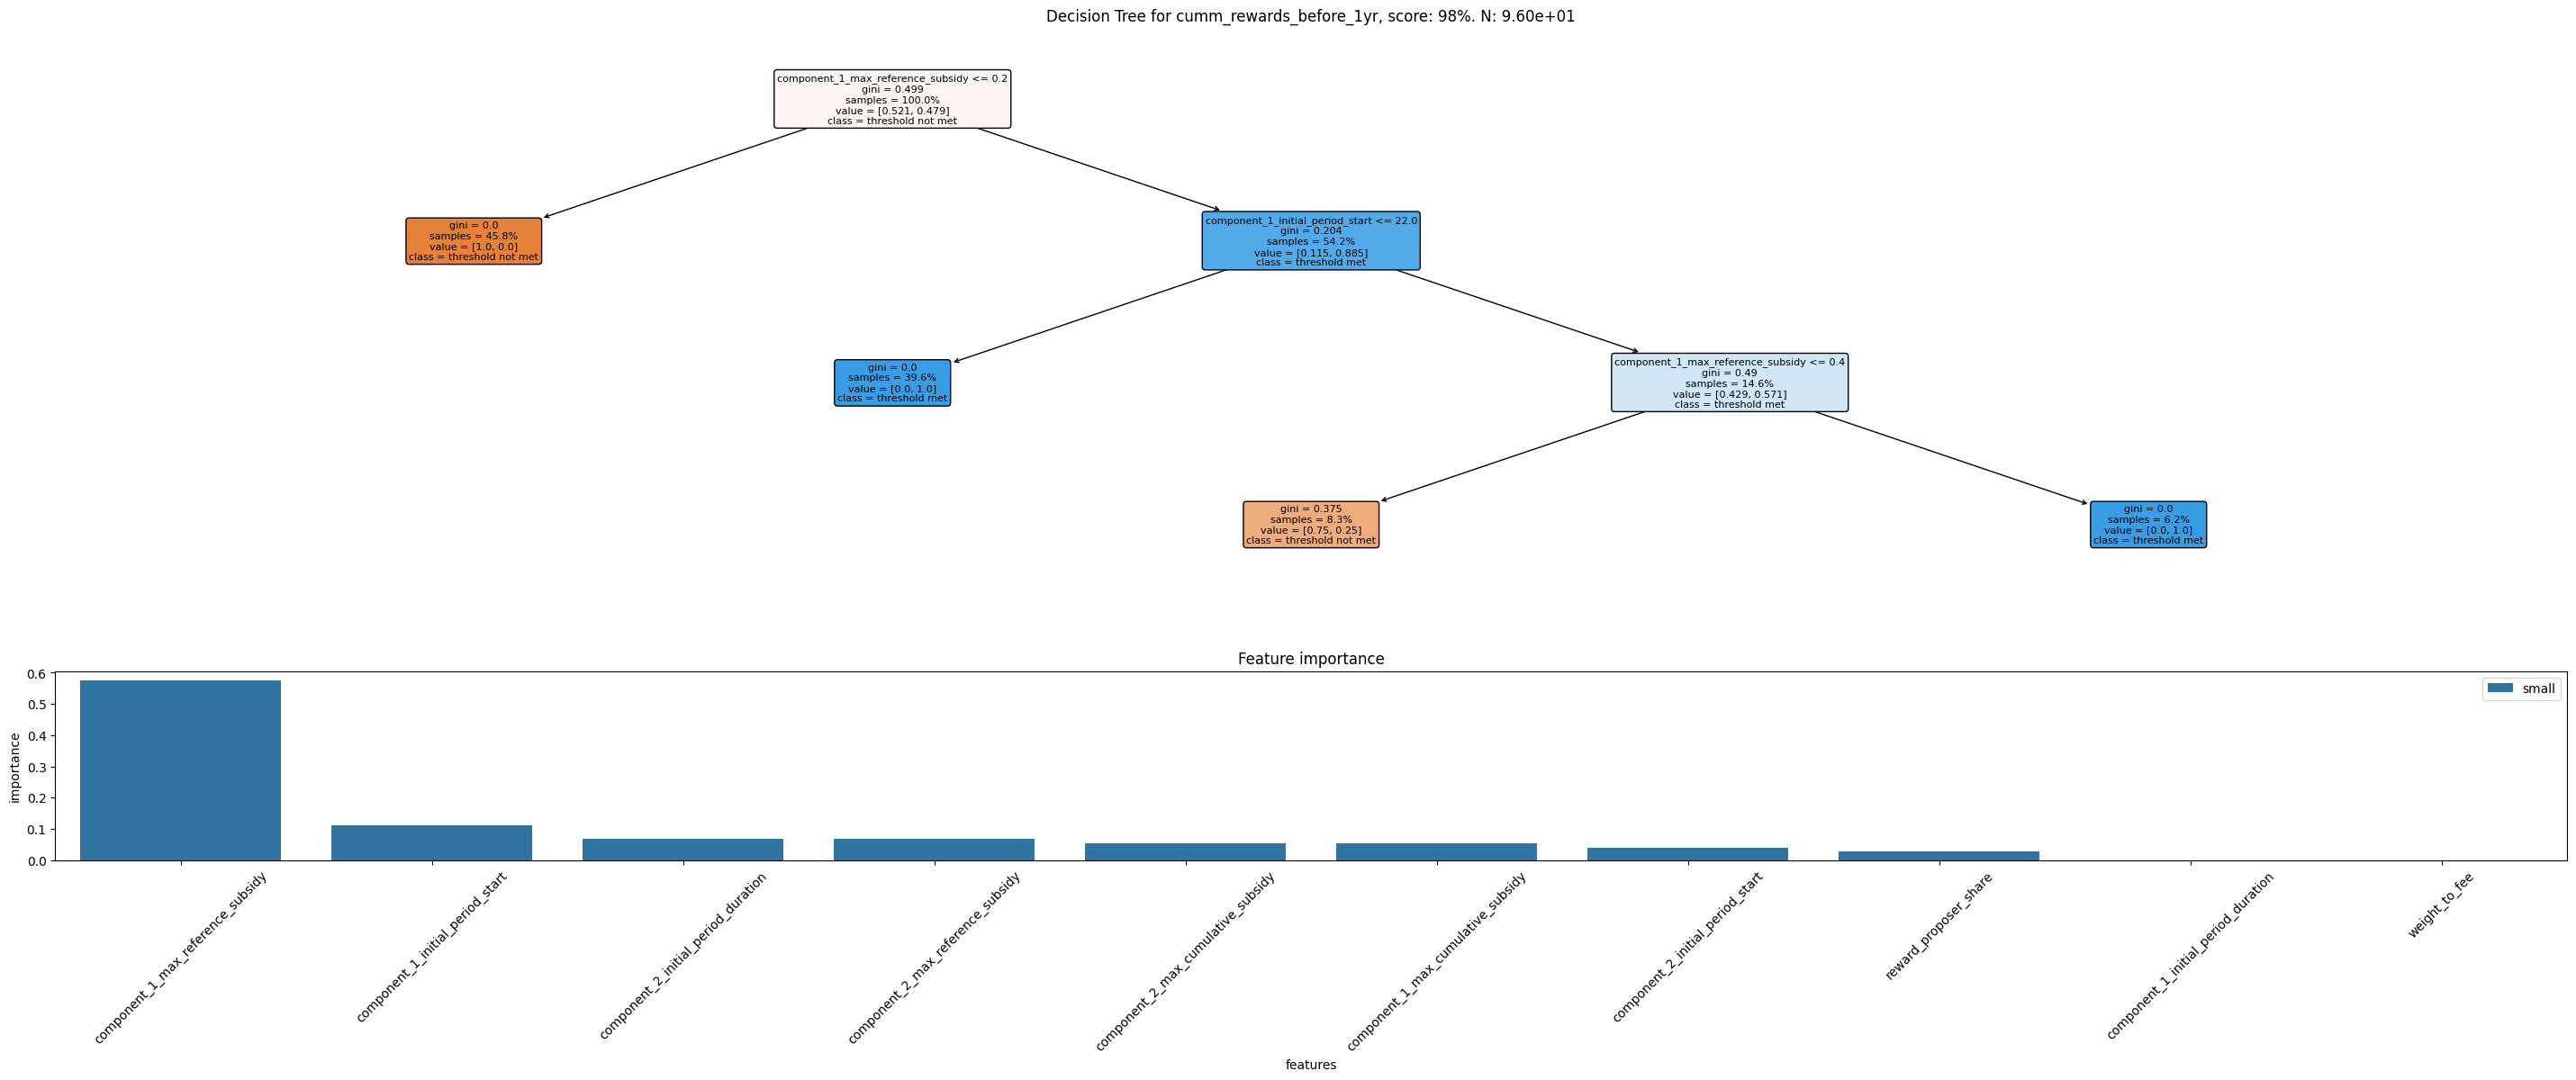

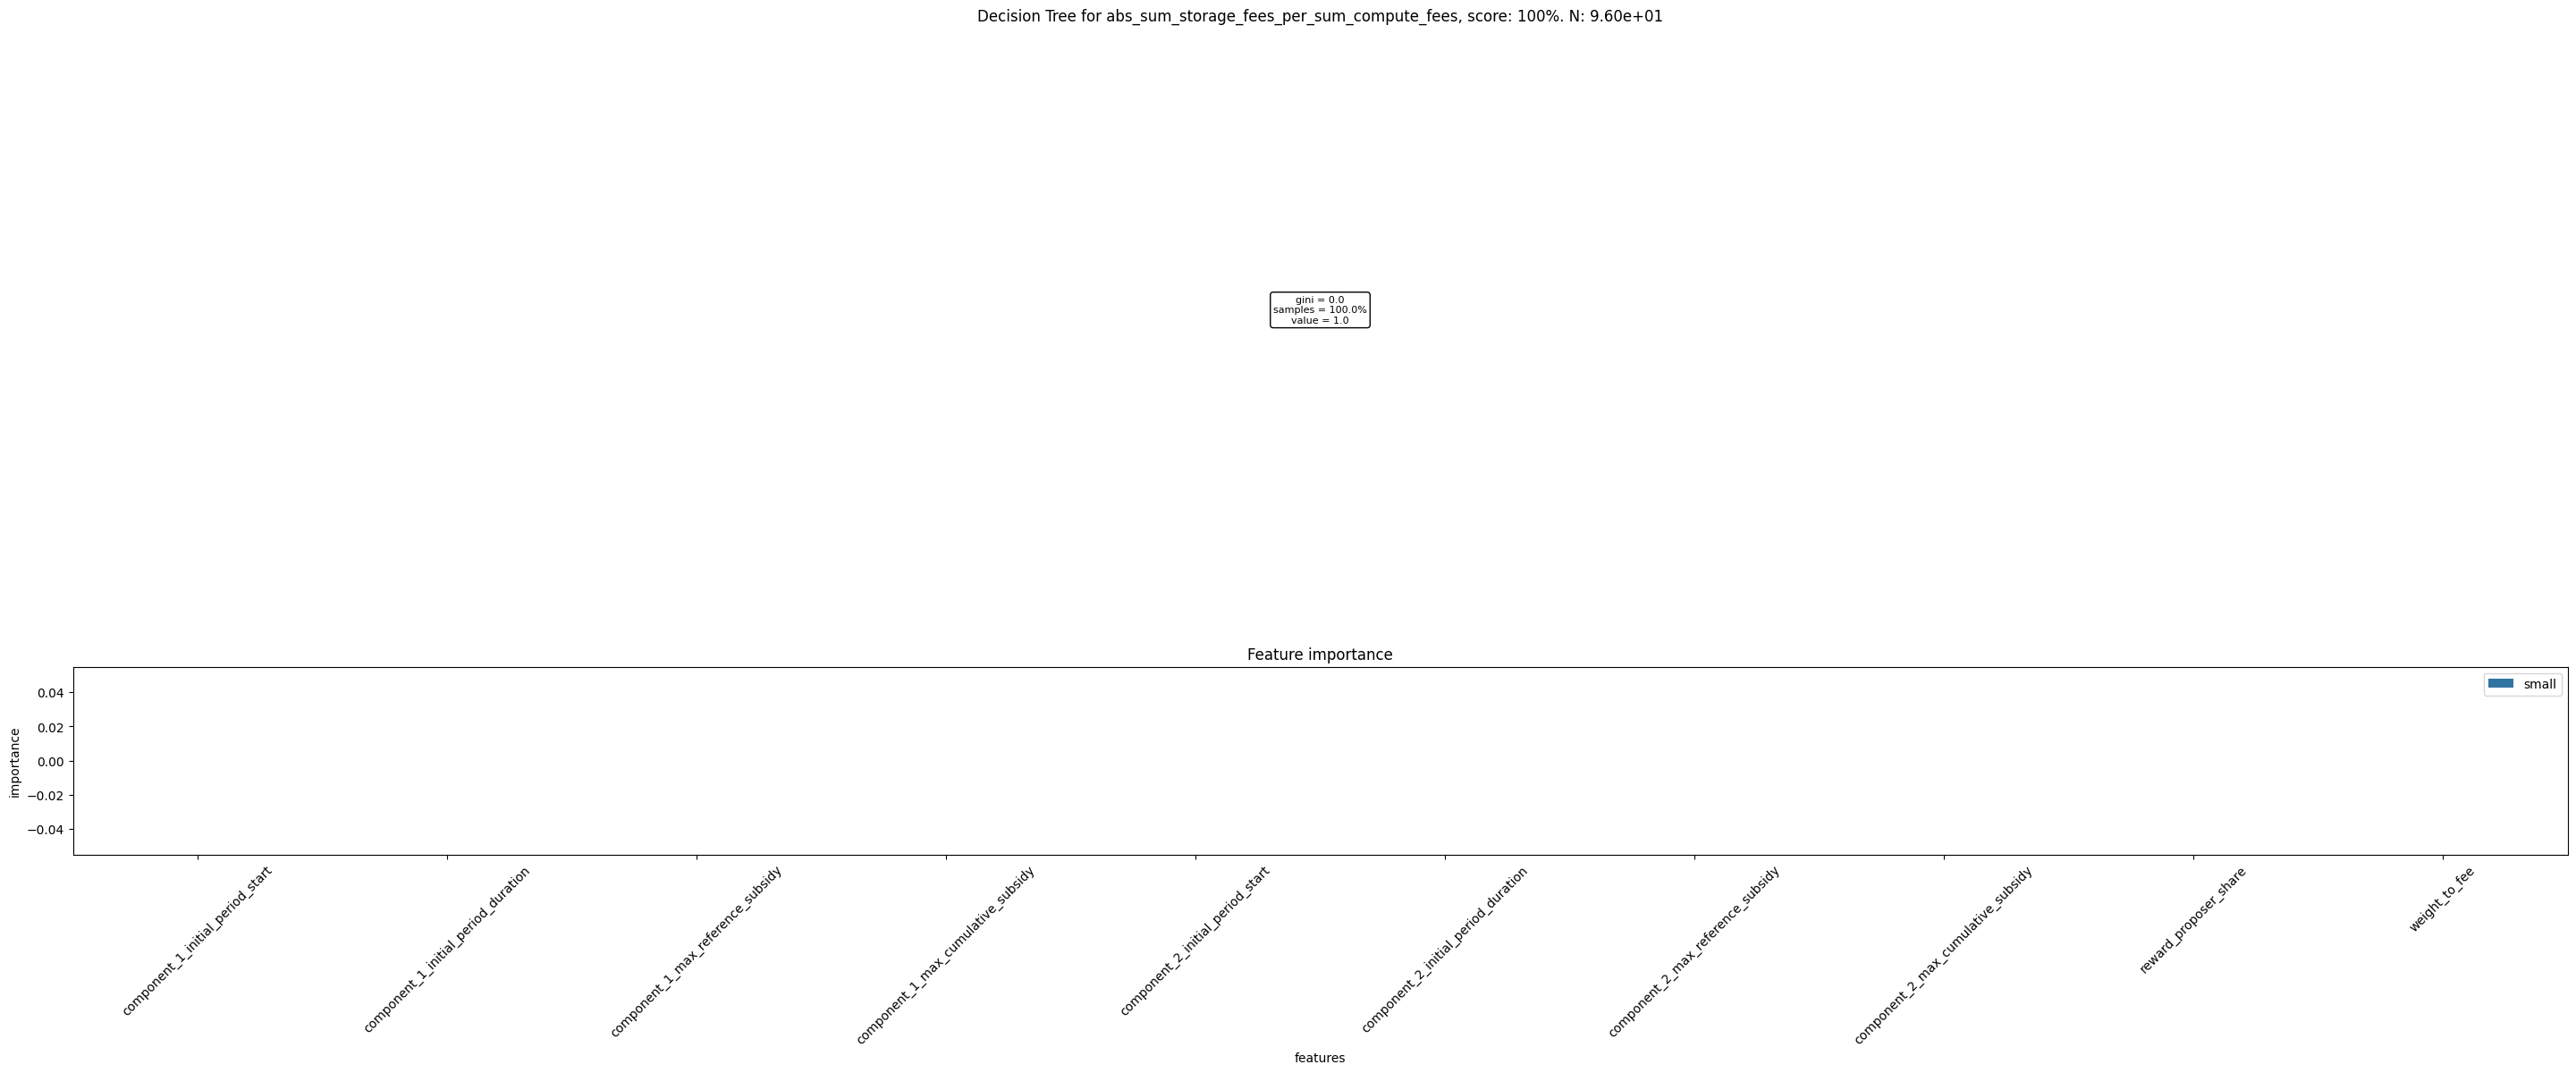

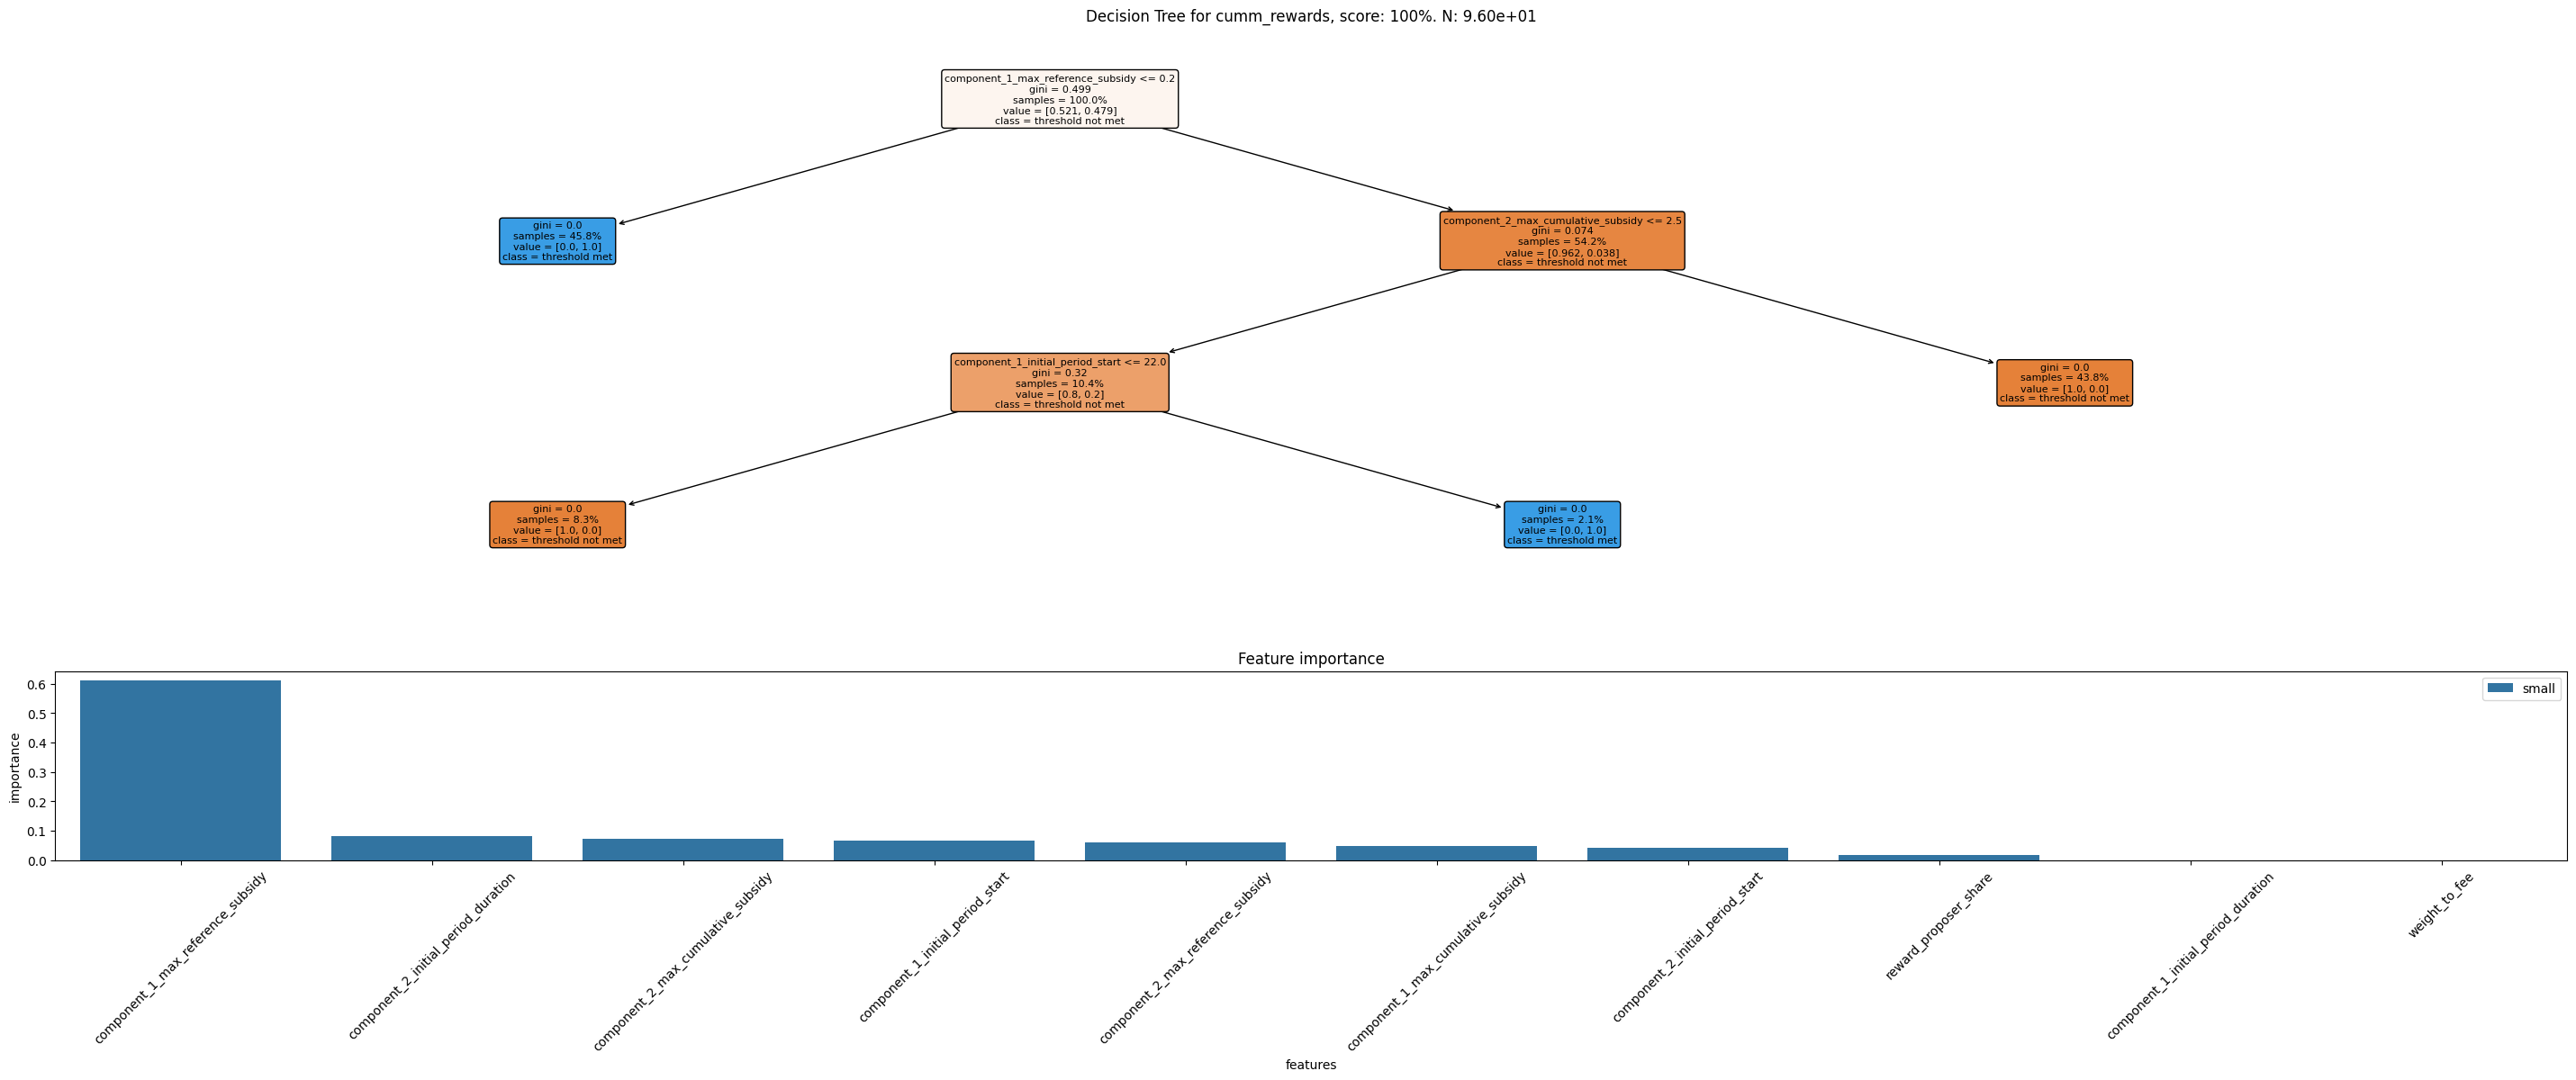

In [9]:
from subspace_model.psuu.plots import create_decision_tree_importances_plot
import matplotlib.pyplot as plt

col_name = "mean_relative_community_owned_supply"
(kpi_f, kpi_t) = KPI_functions[col_name]

for col_name, (kpi_f, kpi_t) in KPI_functions.items():
    create_decision_tree_importances_plot(agg_df,
                                        col_name =col_name,
                                        success_criteria=kpi_t)
    plt.show()